In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pymc as pm
import bambi as bmb
import arviz as az
import statsmodels.api as sm
import numpy as np


### Research Question: What factors impact asthma hospitalizations most greatly in the United States? How can we predict asthma hospitalizations based on demographic (socioeconomic and racial) data and environmental data such as PM2.5 and ozone levels?

### GLM (Frequentist)

In [3]:
df = pd.read_csv('data/full_data.csv')
df.head()

,county,state,ds_o3_pred,ds_pm_pred,hosp_count,white_prop,black_prop,asian_prop,indigenous_prop,other_prop,multiracial_prop,pop,lt_25k_prop,25k_35k_prop,35k_50k_prop,50k_75k_prop,75k_100k_prop,100k_125k_prop,gt_125k_prop
0,Alachua,Florida,36.508214,7.693598,299,0.613028,0.186577,0.064998,0.003048,0.033973,0.098375,278576,0.259452,0.085891,0.120081,0.167524,0.112596,0.074477,0.179979
1,Baker,Florida,36.660481,7.764423,21,0.798461,0.136473,0.006001,0.004340,0.015868,0.038857,29493,0.145195,0.077548,0.130915,0.198979,0.153117,0.099124,0.195122
2,Bay,Florida,38.427998,8.376431,98,0.750248,0.101211,0.024607,0.005843,0.030193,0.087898,178321,0.166087,0.082836,0.134614,0.198470,0.147200,0.093537,0.177256
3,Bradford,Florida,36.882157,7.551175,19,0.742198,0.190572,0.005542,0.002667,0.017180,0.041841,28871,0.259221,0.082684,0.145628,0.202944,0.118355,0.079221,0.111948
4,Brevard,Florida,38.787787,6.407826,281,0.738158,0.098238,0.027283,0.003719,0.033066,0.099536,622701,0.166635,0.086666,0.126523,0.182575,0.132545,0.095496,0.209559


In [112]:
features = ['white_prop', 'black_prop', 'asian_prop', 'indigenous_prop', 'other_prop', 'multiracial_prop', 'pop', 'lt_25k_prop', '25k_35k_prop', '35k_50k_prop', '50k_75k_prop', '75k_100k_prop', '100k_125k_prop', 'gt_125k_prop', 'ds_o3_pred', 'ds_pm_pred']
target = 'hosp_count'

<Figure size 1500x1000 with 0 Axes>

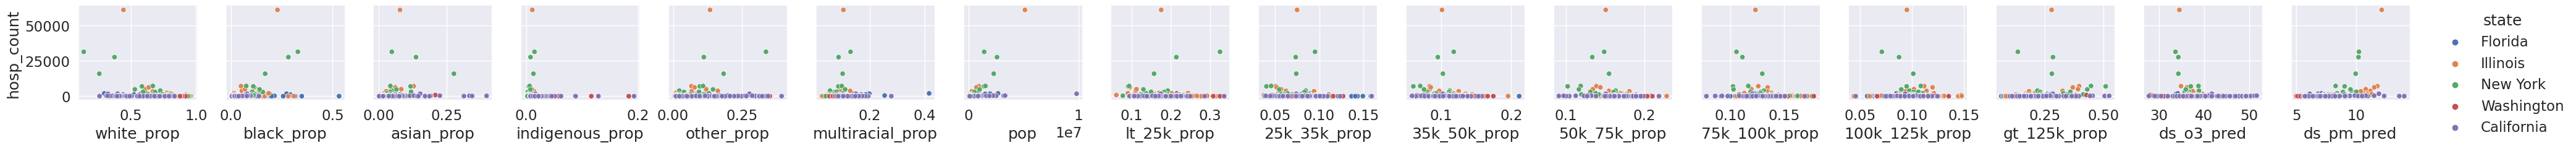

In [113]:
sns.set(font_scale=1.5)  # Set font scale to 1.5
plt.figure(figsize=(15, 10))  # Set the figure size to 15x10 inches
sns.pairplot(df, x_vars=features, y_vars=[target], hue='state')
plt.savefig('pairplot.png')  # Save the plot as a PNG file
plt.show()


### Poisson GLM

In [114]:
pois_model = sm.GLM(
    df.hosp_count, sm.add_constant(df[features]),
    family=sm.families.Poisson()
)
pois_results = pois_model.fit()
print(pois_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             hosp_count   No. Observations:                  320
Model:                            GLM   Df Residuals:                      305
Model Family:                 Poisson   Df Model:                           14
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.0502e+05
Date:                Thu, 02 May 2024   Deviance:                   2.0813e+05
Time:                        21:17:46   Pearson chi2:                 3.51e+05
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.6915      0.122  

### Negative Binomial GLM 

In [115]:
negbin_model = sm.GLM(
    df.hosp_count, sm.add_constant(df[features]),
    family=sm.families.NegativeBinomial()
)
negbin_results = negbin_model.fit()
print(negbin_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             hosp_count   No. Observations:                  320
Model:                            GLM   Df Residuals:                      305
Model Family:        NegativeBinomial   Df Model:                           14
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1976.5
Date:                Thu, 02 May 2024   Deviance:                       615.01
Time:                        21:17:46   Pearson chi2:                     446.
No. Iterations:                    59   Pseudo R-squ. (CS):             0.9542
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                1.6888      0.797  

/srv/conda/envs/notebook/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


In [116]:
print("Poisson Model AIC:", pois_results.aic)
print("Negative Binomial Model AIC:", negbin_results.aic)

Poisson Model AIC: 210071.0234799576
Negative Binomial Model AIC: 3982.9578632997695


The negative binomial model has a much lower AIC, so this will be the model we select out of our frequentist GLMs that work ideally on predicting counts.

### Non-Parametric Methods

### Random Forest

In [117]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.3)

In [118]:
from sklearn.ensemble import RandomForestRegressor

forest_model = RandomForestRegressor(max_features=1)

forest_model.fit(train[features], train[target])

train["forest_pred"] = forest_model.predict(train[features])
test["forest_pred"] = forest_model.predict(test[features])

In [119]:
test.head()

,county,state,ds_o3_pred,ds_pm_pred,hosp_count,white_prop,black_prop,asian_prop,indigenous_prop,other_prop,multiracial_prop,pop,lt_25k_prop,25k_35k_prop,35k_50k_prop,50k_75k_prop,75k_100k_prop,100k_125k_prop,gt_125k_prop,forest_pred
176,Dutchess,New York,36.829013,8.367531,1281,0.701125,0.109034,0.036676,0.004425,0.062378,0.086362,296706,0.130656,0.063388,0.088669,0.141898,0.123332,0.107145,0.344911,1202.19
67,Bond,Illinois,40.551839,10.446565,75,0.864789,0.063309,0.006862,0.003103,0.021362,0.040575,16759,0.182115,0.083538,0.133072,0.187183,0.139120,0.113291,0.161681,166.40
34,Lee,Florida,35.999842,6.778473,505,0.696781,0.077233,0.017622,0.004966,0.074508,0.128889,807051,0.161253,0.085841,0.126001,0.183926,0.138629,0.099473,0.204878,602.00
111,Lake,Illinois,37.187051,10.789604,4939,0.611580,0.068762,0.083403,0.009975,0.120394,0.105886,705582,0.112267,0.056954,0.083379,0.134187,0.119648,0.102033,0.391532,4566.85
299,San Francisco,California,27.812534,9.130403,124,0.413894,0.053605,0.341988,0.007502,0.084151,0.098860,810224,0.138981,0.044730,0.057050,0.090985,0.085750,0.077784,0.504721,3794.25


In [120]:
train_rmse = np.mean((train["forest_pred"] - train["hosp_count"]) ** 2) ** 0.5
test_rmse = np.mean((test["forest_pred"] - test["hosp_count"]) ** 2) ** 0.5

print("Training set error for random forest:", train_rmse)
print("Test set error for random forest:", test_rmse)

Training set error for random forest: 1458.7903652433358
Test set error for random forest: 1883.01932587279


### Decision Tree

In [122]:
from sklearn.tree import DecisionTreeRegressor

tree_model = DecisionTreeRegressor()

tree_model.fit(train[features], train["hosp_count"])

train["tree_pred"] = tree_model.predict(train[features])
test["tree_pred"] = tree_model.predict(test[features])

In [123]:
test.head()

,county,state,ds_o3_pred,ds_pm_pred,hosp_count,white_prop,black_prop,asian_prop,indigenous_prop,other_prop,...,pop,lt_25k_prop,25k_35k_prop,35k_50k_prop,50k_75k_prop,75k_100k_prop,100k_125k_prop,gt_125k_prop,forest_pred,tree_pred
176,Dutchess,New York,36.829013,8.367531,1281,0.701125,0.109034,0.036676,0.004425,0.062378,...,296706,0.130656,0.063388,0.088669,0.141898,0.123332,0.107145,0.344911,1202.19,1248.0
67,Bond,Illinois,40.551839,10.446565,75,0.864789,0.063309,0.006862,0.003103,0.021362,...,16759,0.182115,0.083538,0.133072,0.187183,0.139120,0.113291,0.161681,166.40,196.0
34,Lee,Florida,35.999842,6.778473,505,0.696781,0.077233,0.017622,0.004966,0.074508,...,807051,0.161253,0.085841,0.126001,0.183926,0.138629,0.099473,0.204878,602.00,324.0
111,Lake,Illinois,37.187051,10.789604,4939,0.611580,0.068762,0.083403,0.009975,0.120394,...,705582,0.112267,0.056954,0.083379,0.134187,0.119648,0.102033,0.391532,4566.85,109.0
299,San Francisco,California,27.812534,9.130403,124,0.413894,0.053605,0.341988,0.007502,0.084151,...,810224,0.138981,0.044730,0.057050,0.090985,0.085750,0.077784,0.504721,3794.25,803.0


In [124]:
train_rmse = np.mean((train["tree_pred"] - train["hosp_count"]) ** 2) ** 0.5
test_rmse = np.mean((test["tree_pred"] - test["hosp_count"]) ** 2) ** 0.5

print("Training set error for decision tree:", train_rmse)
print("Test set error for decision tree:", test_rmse)

Training set error for decision tree: 0.0
Test set error for decision tree: 7451.696748895516
